In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Read the dataset
df = pd.read_csv('ICBK Historical Data.csv')

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame by date
df = df.sort_values('Date')

# Convert columns to numeric (in case of commas or non-numeric characters)
# Using 'coerce' will turn non-numeric values to NaN
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
df['High'] = pd.to_numeric(df['High'], errors='coerce')
df['Low'] = pd.to_numeric(df['Low'], errors='coerce')

# Drop rows with NaN values
df.dropna(subset=['Price', 'Open', 'High', 'Low'], inplace=True)

# Extract relevant data columns
data = df[['Price', 'Open', 'High', 'Low']].values

# Initialize MinMaxScaler and scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into training and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


C:\Users\Kalyan GVKK\AppData\Local\Temp\ipykernel_20264\391762635.py:9: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'])


In [25]:
len(train_data)

4264

In [10]:
from hmmlearn.hmm import GaussianHMM

hmm_model = GaussianHMM(n_components=4, covariance_type='diag', n_iter=1000)
hmm_model.fit(train_data)

hidden_states = hmm_model.predict(train_data)

train_data_with_states = np.hstack([train_data, hidden_states.reshape(-1, 1)])
test_data_with_states = np.hstack([test_data, hmm_model.predict(test_data).reshape(-1, 1)])

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length][0]) 
    return np.array(sequences), np.array(labels)

seq_length = 50  
X_train, y_train = create_sequences(train_data_with_states, seq_length)
X_test, y_test = create_sequences(test_data_with_states, seq_length)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=32))
model.add(Dense(units=1)) 

model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
132/132 [==============================] - 9s 42ms/step - loss: 0.0042 - val_loss: 0.0300
Epoch 2/50
132/132 [==============================] - 5s 41ms/step - loss: 6.3442e-04 - val_loss: 0.0243
Epoch 3/50
132/132 [==============================] - 5s 39ms/step - loss: 6.8424e-04 - val_loss: 0.0181
Epoch 4/50
132/132 [==============================] - 5s 39ms/step - loss: 6.3816e-04 - val_loss: 0.0198
Epoch 5/50
132/132 [==============================] - 5s 35ms/step - loss: 6.0522e-04 - val_loss: 0.0140
Epoch 6/50
132/132 [==============================] - 5s 39ms/step - loss: 6.3347e-04 - val_loss: 0.0156
Epoch 7/50
132/132 [==============================] - 3s 24ms/step - loss: 5.7626e-04 - val_loss: 0.0225
Epoch 8/50
132/132 [==============================] - 4s 30ms/step - loss: 5.8311e-04 - val_loss: 0.0143
Epoch 9/50
132/132 [==============================] - 4s 28ms/step - loss: 5.6073e-04 - val_loss: 0.0200
Epoch 10/50
132/132 [==============================] - 4s 3

In [13]:
predicted_prices = model.predict(X_test)

predicted_prices = scaler.inverse_transform(np.hstack([predicted_prices, np.zeros((predicted_prices.shape[0], 3))]))[:, 0]

32/32 [==============================] - 1s 9ms/step


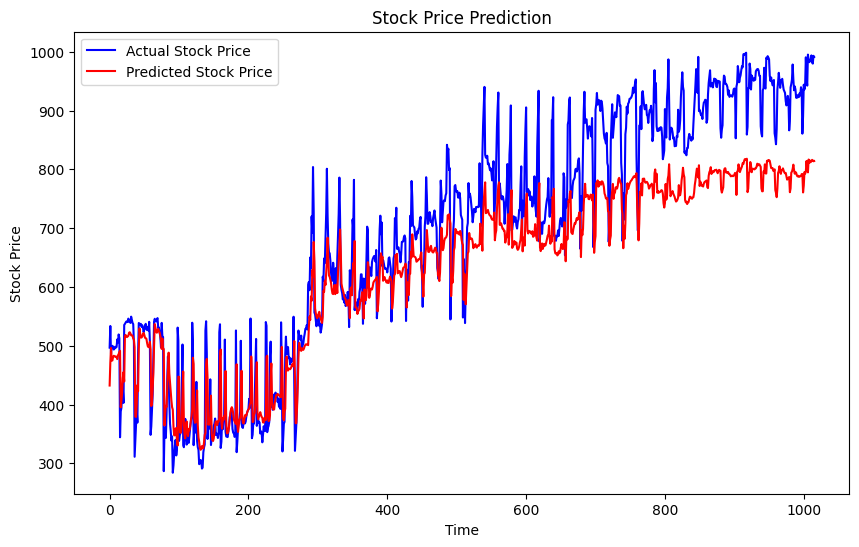

In [14]:
import matplotlib.pyplot as plt

actual_prices = df['Price'].values[train_size + seq_length:]

plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='blue', label='Actual Stock Price')
plt.plot(predicted_prices, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()  

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length][0])  # Predicting 'Price'
    return np.array(sequences), np.array(labels)

seq_length = 50  # Use a sequence length of 50 days for prediction

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

model_lstm = Sequential()
model_lstm.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(LSTM(units=16))
model_lstm.add(Dense(units=1))  # Predict Price

model_lstm.compile(optimizer='adam', loss='mean_squared_error')




In [16]:
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
132/132 [==============================] - 6s 26ms/step - loss: 0.0025 - val_loss: 0.0186
Epoch 2/20
132/132 [==============================] - 3s 22ms/step - loss: 6.1644e-04 - val_loss: 0.0145
Epoch 3/20
132/132 [==============================] - 3s 21ms/step - loss: 6.1677e-04 - val_loss: 0.0138
Epoch 4/20
132/132 [==============================] - 3s 23ms/step - loss: 6.0444e-04 - val_loss: 0.0165
Epoch 5/20
132/132 [==============================] - 3s 24ms/step - loss: 5.8986e-04 - val_loss: 0.0153
Epoch 6/20
132/132 [==============================] - 3s 24ms/step - loss: 6.0202e-04 - val_loss: 0.0141
Epoch 7/20
132/132 [==============================] - 3s 21ms/step - loss: 5.6010e-04 - val_loss: 0.0161
Epoch 8/20
132/132 [==============================] - 3s 22ms/step - loss: 5.3398e-04 - val_loss: 0.0171
Epoch 9/20
132/132 [==============================] - 3s 21ms/step - loss: 5.1882e-04 - val_loss: 0.0141
Epoch 10/20
132/132 [==============================] - 3s 2

In [17]:
# Predict stock prices
predicted_prices_lstm = model_lstm.predict(X_test)
predicted_prices_lstm = scaler.inverse_transform(np.hstack([predicted_prices_lstm, np.zeros((predicted_prices_lstm.shape[0], 3))]))[:, 0]

32/32 [==============================] - 1s 8ms/step


In [18]:
model.save("newModel1.h5")

c:\Users\Kalyan GVKK\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('ICBK Historical Data.csv')


df['Date'] = pd.to_datetime(df['Date'])

df = df.sort_values('Date')


df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
df['High'] = pd.to_numeric(df['High'], errors='coerce')
df['Low'] = pd.to_numeric(df['Low'], errors='coerce')

# Drop rows with NaN values
df.dropna(subset=['Price', 'Open', 'High', 'Low'], inplace=True)

# Extract relevant data columns
data = df[['Price', 'Open', 'High', 'Low']].values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


C:\Users\Kalyan GVKK\AppData\Local\Temp\ipykernel_20264\391762635.py:9: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'])


In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

true_prices = scaler.inverse_transform(np.hstack([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 3))]))[:, 0]
predicted_prices = scaler.inverse_transform(np.hstack([predicted_prices.reshape(-1, 1), np.zeros((predicted_prices.shape[0], 3))]))[:, 0]

mse = mean_squared_error(true_prices, predicted_prices)
mae = mean_absolute_error(true_prices, predicted_prices)
rmse = np.sqrt(mse)
r2 = r2_score(true_prices, predicted_prices)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")


Mean Squared Error (MSE): 398495387926.7199
Mean Absolute Error (MAE): 614817.2464428463
Root Mean Squared Error (RMSE): 631264.9110529746
R-squared (R2): -9692137.572695361


In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf


df = pd.read_csv('ICBK Historical Data.csv')

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
df['High'] = pd.to_numeric(df['High'], errors='coerce')
df['Low'] = pd.to_numeric(df['Low'], errors='coerce')

df.dropna(subset=['Price', 'Open', 'High', 'Low'], inplace=True)

data = df[['Price', 'Open', 'High', 'Low']].values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length][0]) 
    return np.array(sequences), np.array(labels)

seq_length = 50

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=32))
model.add(Dense(units=1))  

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

C:\Users\Kalyan GVKK\AppData\Local\Temp\ipykernel_20264\1496047956.py:14: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'])


Epoch 1/20
132/132 [==============================] - 6s 28ms/step - loss: 0.0016 - val_loss: 0.0116
Epoch 2/20
132/132 [==============================] - 3s 24ms/step - loss: 6.0965e-04 - val_loss: 0.0132
Epoch 3/20
132/132 [==============================] - 3s 24ms/step - loss: 5.8928e-04 - val_loss: 0.0113
Epoch 4/20
132/132 [==============================] - 3s 25ms/step - loss: 5.7344e-04 - val_loss: 0.0111
Epoch 5/20
132/132 [==============================] - 3s 24ms/step - loss: 5.5523e-04 - val_loss: 0.0121
Epoch 6/20
132/132 [==============================] - 3s 24ms/step - loss: 5.0197e-04 - val_loss: 0.0105
Epoch 7/20
132/132 [==============================] - 3s 24ms/step - loss: 4.6192e-04 - val_loss: 0.0132
Epoch 8/20
132/132 [==============================] - 3s 24ms/step - loss: 4.7514e-04 - val_loss: 0.0095
Epoch 9/20
132/132 [==============================] - 3s 24ms/step - loss: 4.5036e-04 - val_loss: 0.0078
Epoch 10/20
132/132 [==============================] - 3s 2

32/32 [==============================] - 1s 11ms/step
Mean Squared Error: 3622.117365005299
Mean Absolute Error: 47.18699605640356
R-squared: 0.9119034636489864


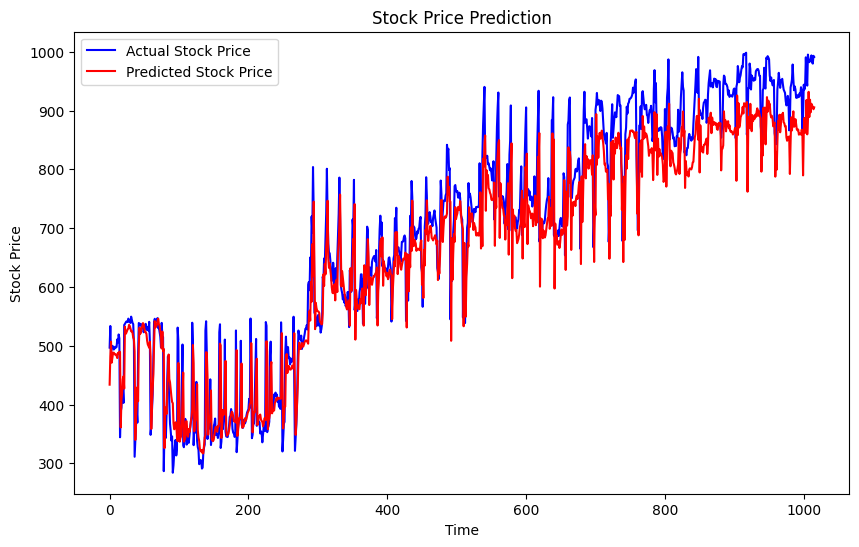

In [34]:
predicted_prices = model.predict(X_test)

predicted_prices_rescaled = scaler.inverse_transform(np.hstack([predicted_prices, np.zeros((predicted_prices.shape[0], 3))]))[:, 0]

true_prices = scaler.inverse_transform(np.hstack([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 3))]))[:, 0]

mse = mean_squared_error(true_prices, predicted_prices_rescaled)
mae = mean_absolute_error(true_prices, predicted_prices_rescaled)
r2 = r2_score(true_prices, predicted_prices_rescaled)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

plt.figure(figsize=(10,6))
plt.plot(true_prices, color='blue', label='Actual Stock Price')
plt.plot(predicted_prices_rescaled, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
